In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
import numpy as np
import os
import segyio
import glob
import pandas as pd

import scipy as sp

from scipy.sparse.linalg import LinearOperator, cg, lsqr

import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *

# EXPERIMENT PARAMS
from pyfrac.hydrafrac.acquisition import recgeom,rec2das_datatrnsfrm,dasgeom

# LOCATION
from pyfrac.modelling.kirchhoff import Kirchhoff
from pyfrac.locationsolvers.imaging import *
from pyfrac.locationsolvers.crosscorr_imaging import xcorr_imaging


# VISUALISATION
from pyfrac.visualisation.traceviz import traceimage, wiggleplot, multiwiggleplot
from pyfrac.visualisation.eventimages import locimage3d
from pyfrac.visualisation.plotting_support import explode_volume


%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
local_modpath = '/home/birniece/Documents/data/ANPERC_Lab/STYLOLITES/StyloliteModels'

seispath = '/home/birniece/Documents/Projects/MicroseismicModelling/ShaheenTransfers/INCOMING/Stylolites/outputs/su'
modpath ='/home/birniece/Documents/Projects/MicroseismicModelling/ShaheenTransfers/OUTGOING/Stylolites/inputs/StyloliteModels/'
figpath = './Figures/StyloliteWaveforms/'

# MODELS
    "NX" : "460",
    "NY" : "460",
    "NZ" : "460",

In [4]:
nx = ny = nz = 460
dx = dy = dz = 0.001
abs_bounds = 30

x, y, z = np.arange(nx-abs_bounds)*dx, np.arange(ny-abs_bounds)*dy, np.arange(nz-abs_bounds)*dz
v0 = 5260



In [5]:
mod = np.fromfile(os.path.join(modpath,'Homogeneous.vp'),dtype='float32').reshape([nx,ny,nz])

In [6]:
mod.shape
mod_nobounds = mod[abs_bounds:-abs_bounds,abs_bounds:-abs_bounds,abs_bounds:-abs_bounds]

In [7]:
def plot_XYslice(vp_mod_sty, abs_bounds):
    fig,ax = plt.subplots(1,1,figsize=[5,5])
    c = ax.imshow(vp_mod_sty[abs_bounds:-abs_bounds,abs_bounds:-abs_bounds,0].T, 
                  aspect='auto', cmap='copper', vmax=np.max(vp_mod_sty), vmin=np.max(vp_mod_sty)*0.7,
                  extent=[0,40,40,0],
                 )
    ax.set_ylabel('y [cm]'); ax.set_xlabel('x [cm]');
    return fig

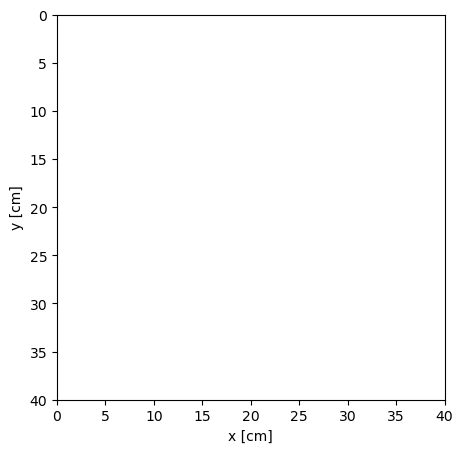

In [8]:
fig = plot_XYslice(mod_nobounds, abs_bounds=0)


In [9]:
# RECEIVERS
recs = np.loadtxt('/home/birniece/Documents/Projects/MicroseismicModelling/ShaheenTransfers/OUTGOING/Stylolites/inputs/gridded_recs.dat').T
recs = recs - (abs_bounds*dx)
nr = recs.shape[1]
nr_per_face = nr//6
print(nr)

150


In [10]:
recs

array([[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
        0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
        0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.4  , 0.4  ,
        0.4  , 0.4  , 0.4  , 0.4  , 0.4  , 0.4  , 0.4  , 0.4  , 0.4  ,
        0.4  , 0.4  , 0.4  , 0.4  , 0.4  , 0.4  , 0.4  , 0.4  , 0.4  ,
        0.4  , 0.4  , 0.4  , 0.4  , 0.4  , 0.011, 0.011, 0.011, 0.011,
        0.011, 0.106, 0.106, 0.106, 0.106, 0.106, 0.2  , 0.2  , 0.2  ,
        0.2  , 0.2  , 0.295, 0.295, 0.295, 0.295, 0.295, 0.39 , 0.39 ,
        0.39 , 0.39 , 0.39 , 0.011, 0.011, 0.011, 0.011, 0.011, 0.106,
        0.106, 0.106, 0.106, 0.106, 0.2  , 0.2  , 0.2  , 0.2  , 0.2  ,
        0.295, 0.295, 0.295, 0.295, 0.295, 0.39 , 0.39 , 0.39 , 0.39 ,
        0.39 , 0.011, 0.106, 0.2  , 0.295, 0.39 , 0.011, 0.106, 0.2  ,
        0.295, 0.39 , 0.011, 0.106, 0.2  , 0.295, 0.39 , 0.011, 0.106,
        0.2  , 0.295, 0.39 , 0.011, 0.106, 0.2  , 0.295, 0.39 , 0.011,
      

# Load Modelled Data

In [11]:
def read_seis(seisfile, nr):
    # s_wave_file = os.path.join(data_path,'test.bin.curl')
    seis_flat = np.loadtxt(seisfile)

    # determine number of timesamples and ensure it saved fully
    nt = int(seis_flat.shape[0] / nr)
    try:
        seis_flat.reshape((nr, nt))
    except:
        print('Not good dims \n nt:%i nr:%i \n vz flat:%i' % (nt, nr, seis_flat.shape[0]))

    # Resample to 2D
    seis = seis_flat[:nt * nr].reshape((nr, nt))
    return seis

In [12]:
homo_div = read_seis(os.path.join(seispath,'Homogeneous_div.txt'), nr)
# sinep90_div = read_seis(os.path.join(seispath,'SineStylo_h10_pc90_div.txt'), nr)
# sinep80_div = read_seis(os.path.join(seispath,'SineStylo_h10_pc80_div.txt'), nr)
# sinep70_div = read_seis(os.path.join(seispath,'SineStylo_h10_pc70_div.txt'), nr)

homo_div /=np.max(abs(homo_div))
# sinep90_div /=np.max(abs(sinep90_div))
# sinep80_div /=np.max(abs(sinep80_div))
# sinep70_div /=np.max(abs(sinep70_div))

homo_div = homo_div[:,37:]
# sinep90_div = sinep90_div[:,37:]
# sinep80_div = sinep80_div[:,37:]
# sinep70_div = sinep70_div[:,37:]

<Axes: title={'center': 'Seismic Recording'}, xlabel='Receiver #', ylabel='Time'>

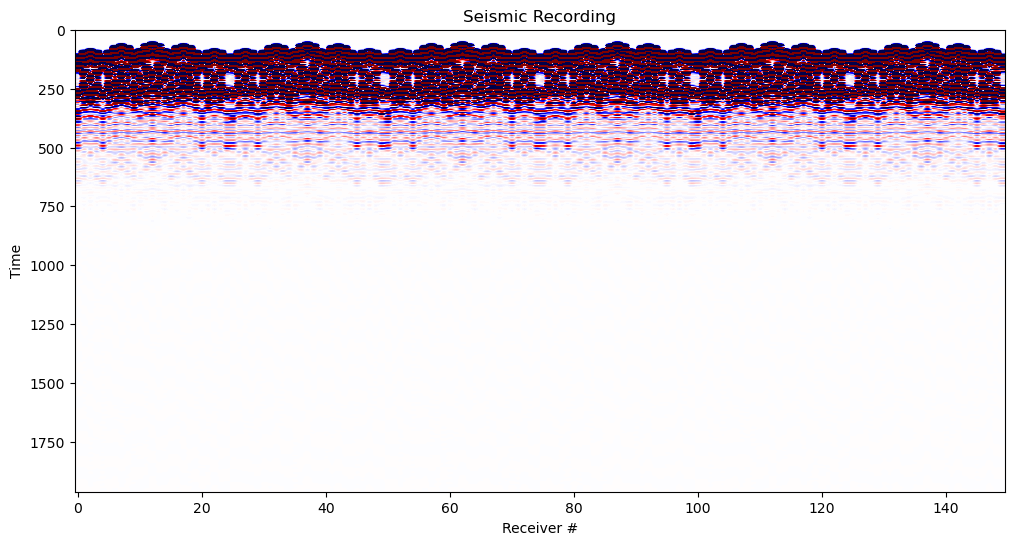

In [13]:
traceimage(homo_div, cbar=False)

In [14]:
homo_div.shape

(150, 1963)

# Modelling Parameters

In [15]:
# TIME AXIS AND WAVELET
dt = 5e-8  # Modelling time step
rndt = 10  # ndt for seismograms
rdt = dt * rndt
nt = homo_div.shape[1]
t = np.arange(nt)*rdt

# fc = 80000
# wav, wavt, wavc = ricker(t[:501], f0=fc)
# plt.plot(wavt,wav)

# print(len(wav), len(wavt), wavc)

96 96 48


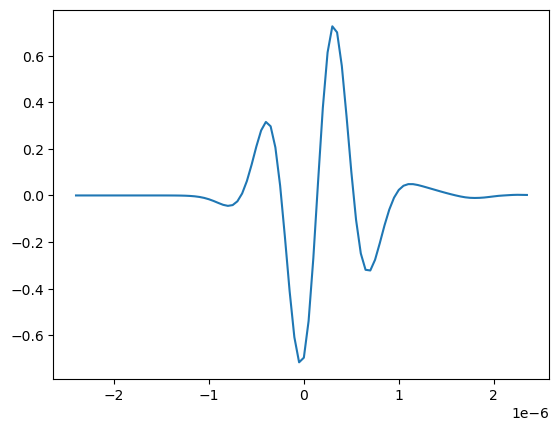

In [16]:
wav = homo_div[10,56:152]
wavt = np.arange(-len(wav)//2,len(wav)//2)*dt
wavc=len(wav)//2
plt.plot(wavt,wav)
print(len(wav), len(wavt), wavc)

In [17]:
# Reduce modelling dims for inversion
dx = dy = dz = 0.005  # 1mm
dimlims = 0.4 
nx = ny = nz = int(dimlims/dx) 
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz
v0 = 5260
print(nx,ny,nz)

# Microseismic sources
sx, sy, sz = [nx//2, ny//2, nz//2]
microseismic = np.zeros((nx, ny, nz))
microseismic[sx, sy, sz] = 1.

80 80 80


In [18]:
# INITIALISE OPERATOR
Op = Kirchhoff(z=z, 
               x=x, 
               y=z, 
               t=t, 
               srcs=recs[:, :1], 
               recs=recs, 
               vel=v0, 
               wav=wav, 
               wavcenter=wavc, 
               mode='analytic', 
               engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

/home/birniece/Documents/Projects/MicroseismicModelling/MicroseismicProcessing/pyfrac/modelling/kirchhoff.py:255: FutureWarning: A new implementation of Kirchhoff is provided in v2.1.0. This currently affects only the inner working of the operator, end-users can continue using the operator in the same way. Nevertheless, it is now recommended to providethe variables trav (and amp) as a tuples containing the traveltime (and amplitude) tables for sources and receivers separately. This behaviour will eventually become default in version v3.0.0.
  warnings.warn(


Dot test passed, v^H(Opu)=-9389.341420002509 - u^H(Op^Hv)=-9389.341420002545


In [23]:
vz_file_list = glob.glob(seispath+'/*div.txt')
inv = np.zeros([len(vz_file_list), nx,ny,nz])
inv_hc = np.zeros([len(vz_file_list), 3, 1])
expname_list = []

for i,vz_file in enumerate(vz_file_list):
    expname = vz_file.split('/')[-1][:-8]
    expname_list.append(expname)
    print(expname)
    
    vz = read_seis(vz_file, nr)
    vz/=np.max(abs(vz))
    vz = vz[:,37:]

    inv[i], inv_hc[i] = lsqr_migration(Op, vz, [nx,ny,nz], nforhc=1, verbose=False)

InclinedStylo_a-15_pc70
StraightStylo_w02_pc90
InclinedStylo_a45_pc80
InclinedStylo_a15_pc90
PinchOutStylo_pc70
InclinedStylo_a-05_pc90
SineStylo_h20_pc90
InclinedStylo_a05_pc90
SineStylo_h15_pc90
InclinedStylo_a-35_pc80
InclinedStylo_a-15_pc90
InclinedStylo_a25_pc70
SineStylo_h05_pc80
InclinedStylo_a-25_pc80
InclinedStylo_a05_pc70
InclinedStylo_a05_pc80
InclinedStylo_a35_pc70
SineStylo_h20_pc80
InclinedStylo_a-45_pc80
StraightStylo_w03_pc90
StraightStylo_w04_pc80
StraightStylo_w05_pc90
StraightStylo_w03_pc80
InclinedStylo_a35_pc80
InclinedStylo_a-05_pc70
StraightStylo_w01_pc70
InclinedStylo_a-25_pc90
InclinedStylo_a45_pc90
StraightStylo_w05_pc70
InclinedStylo_a15_pc80
SineStylo_h10_pc90
InclinedStylo_a15_pc70
InclinedStylo_a-15_pc80
StraightStylo_w04_pc70
StraightStylo_w01_pc80
StraightStylo_w02_pc80
StraightStylo_w02_pc70
InclinedStylo_a-35_pc90
SineStylo_h05_pc70
PinchOutStylo_pc80
SineStylo_h20_pc70
StraightStylo_w03_pc70
InclinedStylo_a-25_pc70
InclinedStylo_a25_pc90
StraightStylo

In [35]:
background_rms = np.zeros(len(inv))
maxima_value = np.zeros(len(inv))
for i,inv_exp in enumerate(inv):
    maxima_value[i] = inv_exp[int(inv_hc[i][0]), int(inv_hc[i][1]), int(inv_hc[i][2])]
    a = np.ma.array(inv_exp, mask=False)
    a.mask[int(inv_hc[i][0]), int(inv_hc[i][1]), int(inv_hc[i][2])] = True
    background_rms[i] = np.sqrt(np.mean(a**2))

In [52]:
inv_hc.squeeze().shape

(61, 3)

In [38]:
snr = maxima_value/background_rms

In [53]:
df = pd.DataFrame({'experiment':expname_list, 
                   'maxima_location_x':inv_hc.squeeze()[:,0], 
                   'maxima_location_y':inv_hc.squeeze()[:,1], 
                   'maxima_location_z':inv_hc.squeeze()[:,2], 
                   'maxima_value':maxima_value, 
                   'background_rms':background_rms, 
                   'imaging_snr':snr})

In [54]:
df.sort_values('experiment')

,experiment,maxima_location_x,maxima_location_y,maxima_location_z,maxima_value,background_rms,imaging_snr
58,Homogeneous,40.0,40.0,40.0,0.007920,0.000134,58.918585
24,InclinedStylo_a-05_pc70,40.0,40.0,40.0,0.006335,0.000122,51.966479
55,InclinedStylo_a-05_pc80,40.0,40.0,40.0,0.006838,0.000120,56.958167
5,InclinedStylo_a-05_pc90,40.0,40.0,40.0,0.007367,0.000125,58.908956
0,InclinedStylo_a-15_pc70,40.0,40.0,40.0,0.007623,0.000130,58.497676
...,...,...,...,...,...,...,...
20,StraightStylo_w04_pc80,40.0,40.0,40.0,0.007271,0.000132,54.939518
47,StraightStylo_w04_pc90,40.0,40.0,40.0,0.007723,0.000130,59.389468
28,StraightStylo_w05_pc70,40.0,40.0,40.0,0.005772,0.000160,36.150982
44,StraightStylo_w05_pc80,40.0,40.0,40.0,0.006969,0.000134,51.979643


In [55]:
df.to_csv('./StylolitesImagingAnalysis.csv')

In [68]:
for i,inv_exp in enumerate(inv):
    fig,axs = locimage3d(inv_exp, x0=sx, y0=sy, clipval=[-0.0025,0.0025], cmap='RdBu')
    fig.suptitle('LSQR - '+ expname_list[i] + '\nHypocenter: '+ 
                 str(inv_hc[i][0][0]*dx) + ', ' +
                 str(inv_hc[i][1][0]*dx) + ', ' + 
                 str(inv_hc[i][2][0]*dx))
    fig.tight_layout()
    fig.savefig('./Figures/StyloliteImages/LSQR_'+expname_list[i]+'.eps', format='eps')
    plt.close()

/tmp/ipykernel_2600/1523927977.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


In [73]:
for i,inv_exp in enumerate(inv):
    fig,axs = locimage3d(abs(inv_exp), x0=sx, y0=sy, clipval=[0,0.0025], cmap='hot_r')
    fig.suptitle('LSQR - '+ expname_list[i] + '\nHypocenter: '+ 
                 str(inv_hc[i][0][0]*dx) + ', ' +
                 str(inv_hc[i][1][0]*dx) + ', ' + 
                 str(inv_hc[i][2][0]*dx))
    fig.tight_layout()
    fig.savefig('./Figures/StyloliteImages/LSQRabs_'+expname_list[i]+'.eps', format='eps')
    plt.close()

/tmp/ipykernel_2600/733555116.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


In [65]:
df.sort_values('imaging_snr')

,experiment,maxima_location_x,maxima_location_y,maxima_location_z,maxima_value,background_rms,imaging_snr
28,StraightStylo_w05_pc70,40.0,40.0,40.0,0.005772,0.000160,36.150982
33,StraightStylo_w04_pc70,40.0,40.0,40.0,0.006414,0.000153,41.979053
41,StraightStylo_w03_pc70,40.0,40.0,40.0,0.007010,0.000144,48.798374
24,InclinedStylo_a-05_pc70,40.0,40.0,40.0,0.006335,0.000122,51.966479
44,StraightStylo_w05_pc80,40.0,40.0,40.0,0.006969,0.000134,51.979643
...,...,...,...,...,...,...,...
34,StraightStylo_w01_pc80,40.0,40.0,40.0,0.007877,0.000132,59.534068
1,StraightStylo_w02_pc90,40.0,40.0,40.0,0.007862,0.000132,59.539053
48,InclinedStylo_a25_pc80,40.0,40.0,40.0,0.007895,0.000133,59.557096
19,StraightStylo_w03_pc90,40.0,40.0,40.0,0.007798,0.000131,59.559116


In [ ]:
inv.shape
inv_maxima = inv[:,40,40,40]

In [ ]:
inv[:,41,41,41]

In [ ]:
inv_maxima

In [ ]:
rms = np.sqrt(np.mean(inv[0]**2))

In [ ]:
rms = np.sqrt(np.mean(inv[3]**2))
rms